In [1]:
!pip install pandas fiona shapely pyproj rtree 
!pip install contextily
!pip install geopandas
!pip install topojson
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 42.8 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [fiona]32m3/4 [fiona]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 33.6 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [contextily]7 [geopy]io]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [2]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
#### On importe le fichier répertoriant les catastrophes naturelles de type inondations reconnues pour chaque commune

import requests

# Téléchargement du fichier avec le nombre de catastrophes reconnues pour chaque commune, directement depuis le site Géorisques
url_inondations = "https://files.georisques.fr/onrn/2025/ONRN_Reco_INON_8224.xlsx"
response_inondations = requests.get(url_inondations)

# Enregistrement du fichier localement
with open("ONRN_Reco_INON_8224.xlsx", "wb") as f:
    f.write(response_inondations.content)

# Importation et ouverture avec Pandas
inondations = pd.read_excel("ONRN_Reco_INON_8224.xlsx", sheet_name="Nb reco. Cat Nat")
inondations.head()

,Code INSEE,Commune,"Nombre de reconnaissances Cat Nat\n inondation (tous types)\n(Somme : coulée de boue, remontée de nappe, submersion marine)"
0,01001,L'Abergement-Clémenciat,2
1,01002,L'Abergement-de-Varey,2
2,01004,Ambérieu-en-Bugey,4
3,01005,Ambérieux-en-Dombes,2
4,01006,Ambléon,1


In [11]:
#### Et on importe le fichier avec les shapefiles des communes

# Téléchargement du fichier avec les shapefiles des communes, directement depuis Datagouv
url_communes = "https://www.data.gouv.fr/api/1/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165"
zip_communes = "shapefiles.zip"

# Enregistrement du fichier localement
response_communes = requests.get(url_communes)
with open(zip_communes, "wb") as f:
    f.write(response_communes.content)

# Importation avec GeoPandas
communes = gpd.read_file(f"zip://{zip_communes}!communes-20220101.shp")
communes.head()

,insee,nom,wikipedia,surf_ha,geometry
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.3851, 9..."
1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.2001 42.39013, 9.20014 42.39014, 9..."
2,2B051,Cambia,fr:Cambia,833.0,"POLYGON ((9.27757 42.37509, 9.27758 42.37512, ..."
3,2B106,Érone,fr:Érone,393.0,"POLYGON ((9.2512 42.37605, 9.25132 42.37603, 9..."
4,2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((9.2834 42.66273, 9.28345 42.66273, 9..."


In [12]:
### Préparation du dataframe de travail

# On renomme la colonne avec le code INSEE dans le df des communes (shapefiles) pour le joindre à celui tiré de Géorisques
communes = communes.rename(columns={"insee" : "Code INSEE"})
communes.head()

# On fait la jointure
df = pd.merge(communes, inondations, on="Code INSEE")

# On supprime la colonne wikipedia (inutile) et nom (identique à la colonne 'Commune')
del df['wikipedia']
del df['nom']
df.head()

# On réorganise le df (ordre des colonnes)
df = df.iloc[:,[3,0,1,2,4]]

# On renomme la dernière colonne (pour pouvoir l'appeler facilement)
df.columns = ['Commune', 'Code INSEE', 'surf_ha', 'geometry', 'Occurrences'] 

# On remplace "Pas de reconnaissance" par 0 (on transforme la ligne en numérique : les erreurs (ie les caractères) sont alors convertis en 0)
df["Occurrences"] = pd.to_numeric(df["Occurrences"], errors="coerce").fillna(0) 

In [13]:
### Statistiques descriptives (pour vérifier que tout fonctionne)

# Moyenne
df['Occurrences'].mean()

# Variance
df['Occurrences'].var()

np.float64(7.790261657471829)

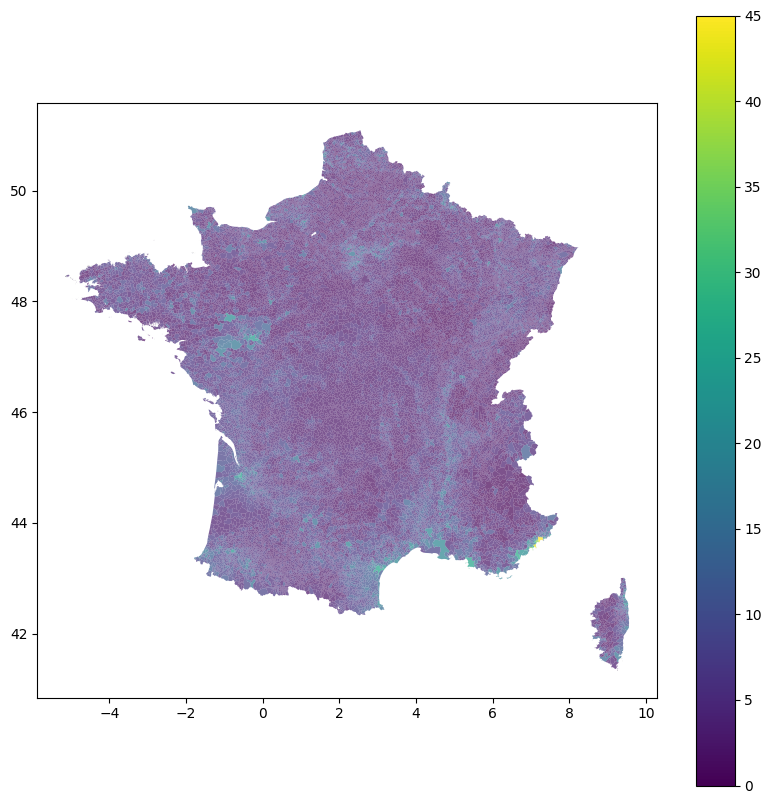

In [14]:
### Cartographie

# Conversion du fichier au format GeoPandas
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Utilisation de l'epsg=4326
gdf.set_crs(epsg=4326, inplace=True)

# Premier plot (villes coloriées selon l'occurrence des inondations)
ax = gdf.plot(
    column='Occurrences',      # on utilise la colonne 'Occurrences' pour colorer différemment les villes
    cmap='viridis',            # code pour colorier
    legend=True,               # on affiche la légende (couleurs sur la droite)
    markersize=50,             # taille des points (à revoir éventuellement)
    figsize=(10, 10),          # taille de la figure (idem)
    alpha=0.7                  # transparence
)
plt.show()